# Neural Network from Scratch


## Importing libraries

We will use the lower resolution MINST data set

In [11]:
import numpy as np
from typing import List
from typing import Tuple
from functools import partial
from tqdm.notebook import tqdm
from collections.abc import Sequence
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits  # The MNIST data set
from sklearn.preprocessing import (
    StandardScaler,
)  # It is important in neural networks to scale the date
from sklearn.model_selection import (
    train_test_split,
)  # The standard train test split to prevent overfitting and choose hyperparameters

DEBUG = True

## Exploring the dataset

The shape of the digits dataset: (1797, 64)


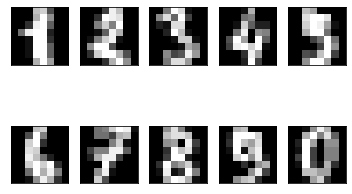

In [2]:
# load all the digits dataset from the sklearn library

digits = load_digits()
X, y = digits.data, digits.target
print("The shape of the digits dataset:", X.shape)


def plt_digit(x, h, w):
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])


def display_digits(X, height, width, num_images=10):
    if num_images & 1 or num_images == 0:
        raise ValueError("Only even values (>=2) for num_images allowed")
    fig = plt.figure()
    for i in range(1, num_images + 1):
        fig.add_subplot(2, num_images // 2, i)
        plt_digit(X[i], height, width)
    plt.gray()
    plt.show()


display_digits(X, 8, 8)

## Scale the dataset
To speed the weight convergence, the training features must be scaled to have a mean of 0 and unit variance

In [3]:
# Using the StandardScaler to standardize our X_feat
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Looking the new features after scaling
X_scaled

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

## Creating training and test datasets

We split the data into training and test data sets with 60-40 split. 

We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.40, random_state=1
)

## Setting up the output layer

### One hot encoding

In [15]:
def convert_y_to_vect(y):
    """
    One Hot Encoding for target
    Converts into a 10 element array

    y can be an integer or a Sequence of integers
    """
    if isinstance(y, int):
        return np.array([1 if i == y else 0 for i in range(10)])
    elif isinstance(y, Sequence) or isinstance(y, np.ndarray):
        return np.array([[1 if i == target else 0 for i in range(10)] for target in y])

Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors using the func above
y_train_vect, y_test_vect = convert_y_to_vect(y_train), convert_y_to_vect(y_test)

In [7]:
if DEBUG:
    print(y_train[0:4])
    print((y_train_vect[0:4]))

[3 5 4 4]
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


## Creating the neural network

### Utility Activation Functions

**The activation function and its derivative**

Sigmoid activation function $\sigma(z) = \frac{1}{1+e^{-z}}$

Sigmoid derivative function $\sigma'(z) = \sigma(z)(1-\sigma(z))$

RELU activation function $relu(z) = max(0, m*z)$ where m=1

RELU derivative function $  
relu'(z) = 
     \begin{cases}
       \text{0} &\quad\text{if z} \ge 0 \\
       \text{1} &\quad\text{if z} \lt 0 \\
     \end{cases}
$

Tanh activation function $tanh(z) = \frac{e^{2z}-1}{e^{2z}+1}$

Tanh derivative function $tanh'(z) = 1 + tanh(z)^2$

In [12]:
def sigmoid(z):
    return 1 / (1 + np.e ** (-z))


def sigmoid_deriv(z):
    return sigmoid(z) * (1 - sigmoid(z))


def tanh(z):
    return (np.e ** (2 * z) - 1) / (np.e ** (2 * z) + 1)


def tanh_deriv(z):
    return 1 - tanh(z) ** 2


def relu(z, m=0):
    """
    default RELU = max(0, z) and m=0
    """
    return np.where(z > 0, z, z * m)


def relu_deriv(z, m=0):
    z[z < 0] = m
    z[z == 0] = 0
    z[z > 0] = 1
    return z


leaky_relu = partial(relu, m=0.01)
leaky_relu_deriv = partial(relu_deriv, m=0.01)

### Loss functions

In [13]:
def squared_error(y_pred, y_test):
    return np.sqrt((np.sum(y_pred - y_test)) ** 2)

### Creating and initializing W and b

W = weights of the neurons

b = biases of the neurons

The weights in W are different so that during back propagation, the nodes on a level will have different gradients and thus have different update values.

The weights are randomly initialized from the uniform range \[0.0, 1.0\). The weights have to be small as the sigmoid flats out for large inputs

In [14]:
def init_weight_and_bias(nn_structure: List[int]):
    """
    nn_structure is a list that reprs the number of neurons in the NN layer
    We use the Kaiming Initialization for the weights
    """
    weights, bias = {}, {}

    # first layer is input layer so we do not save weights for it
    for layer, n_neurons in enumerate(nn_structure[1:], start=1):
        weights[layer] = np.random.random(
            (n_neurons, nn_structure[layer - 1])
        ) / np.sqrt(n_neurons)
        bias[layer] = np.random.random(n_neurons)

    return weights, bias

### Initializing the weight and bias gradient dicts $\triangledown W$ and $\triangledown b$


In [11]:
def init_weight_and_bias_gradients(nn_structure: List[int]):
    delta_W, delta_b = {}, {}

    for layer, n_neurons in enumerate(nn_structure[1:], start=1):
        delta_W[layer] = np.zeros((n_neurons, nn_structure[layer - 1]))
        delta_b[layer] = np.zeros(n_neurons)

    return delta_W, delta_b

## Feed forward

The feed_forward function returns the values of $a$ and $z$

In [12]:
def feed_forward(x, W, b):
    """
    x is a single data point / 1D array
    """
    # a in layer 1 is the input x itself
    a = {1: x}  # holds values of 'a' for all layers, a = func_activation(z)
    z = {}  # holds values of 'z' for all layers, z = Wx + b
    X_feat = x

    for layer, (weight, bias) in enumerate(zip(W, b), start=2):
        z[layer] = W[layer - 1].dot(X_feat) + b[layer - 1]
        a[layer] = sigmoid(z[layer])
        X_feat = a[layer]

    return a, z

## Computing $\delta$

$\delta^{(s_l)}$ is computed in "calculate_out_layer_delta"  

$delta^{nl} = -(y_i - a_i^{nl}) * f'(z_i^{nl})$

$\delta^{(\ell)}$ is computed for the hidden layers in "calculate_hidden_delta" 
    
$delta^{l} = (transpose(W^{l}) * delta^{l+1}) * f'(z^{l})$

In [13]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y - a_out) * sigmoid_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return (w_l.T @ delta_plus_1) * sigmoid_deriv(z_l)

## The Back Propagation Algorithm


In [ ]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    """
    X must be np.ndarray
    """
    W, b = init_weight_and_bias(nn_structure)
    m, n = X.shape
    mse_cost_overtime = []
    print("Starting gradient descent for {} iterations".format(iter_num))
    for epoch in tqdm(range(iter_num)):
        delta_W, delta_b = init_weight_and_bias_gradients(nn_structure)
        cost = 0

        for data_idx, data in enumerate(X):
            # feed forward pass saves a and z values to be used in gradient descent
            a, z = feed_forward(data, W, b)
            deltas = {}
            # loop from n-1 to 1 backpropagating the errors
            for layer in range(len(nn_structure), 0, -1):
                if layer == len(nn_structure):  # layer is output layer
                    deltas[layer] = calculate_out_layer_delta(
                        y[data_idx, :], a[layer], z[layer]
                    )
                    # squared error calculation
                    cost += np.sqrt(np.sum((a[layer] - y[data_idx, :]) ** 2))
                else:
                    if layer > 1:  # layer is hidden layer
                        deltas[layer] = calculate_hidden_delta(
                            deltas[layer + 1], W[layer], z[layer]
                        )

                    # np.newaxis increases the number of dimensions
                    # delta_W^(l) = delta_W^(l) + deltas^(l+1) * transpose(a^(l))
                    delta_W[layer] += (
                        deltas[layer + 1][:, np.newaxis] @ a[layer][:, np.newaxis].T
                    )
                    # delta_b^(l) = delta_b^(l) + deltas^(l+1)
                    delta_b[layer] += deltas[layer + 1]

        # perform the gradient descent step for the weights in each layer
        for layer in range(len(nn_structure) - 1, 0, -1):
            W[layer] += -alpha * (delta_W[layer] / m)
            b[layer] += -alpha * (delta_b[layer] / m)

        mse_cost = cost / m
        mse_cost_overtime.append(mse_cost)

        # print the iteration number for every 1000 iter
        if epoch % 500 == 0:
            print("At iteration", epoch, "loss is ", mse_cost_overtime[epoch])

    return W, b, mse_cost_overtime

In [ ]:
def predict_y(W, b, X, n_layer_idx):
    m, n = X.shape
    y_pred = np.zeros((m,))

    for i, data in enumerate(X):
        a, _ = feed_forward(data, W, b)
        y_pred[i] = np.argmax(a[n_layer_idx])

    return y_pred

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit). 

Our hidden layer has 30 neurons.  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

In [40]:
nn_structure = [64, 40, 10]

# train the NN with the nn_structure and 3000 iterations
trained_weight, trained_bias, mse_cost_overtime = train_nn(
    nn_structure, X_train, y_train_vect, iter_num=3000, alpha=0.25
)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
2.6944973832931636
2.4633789885205264
2.1860273444487004
1.5168596574156261
0.9206211161581933
0.9015084703120053
0.8768541454256381
0.8463840688831413
0.812778845138156
0.779295141483779
Iteration 1000 of 3000
0.7475449067630495
0.7180110136403702
0.6908108752528597
0.6658160961323221
0.6427062709074396
0.6211077537698336
0.6007257853493224
0.5814056668455474
0.5631136062399519
0.5458955067028896
Iteration 2000 of 3000
0.5298039822140685
0.5148426203737275
0.5009509114765441
0.48802376840681494
0.4759448430582288
0.46460731169758923
0.45391906913315067
0.44380046715845783
0.43418010765376797
0.42499180152083244


### Plotting the learning curve


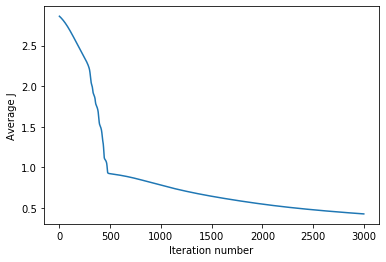

In [41]:
# plot the avg_cost_func
plt.plot(mse_cost_overtime)
plt.xlabel("Iteration number")
plt.ylabel("Average J")
plt.show()

## Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [42]:
y_pred = predict_y(trained_weight, trained_bias, X_test, len(nn_structure))
print("Prediction accuracy is {:5f}%".format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 88.595271%


## Neural Network OOP model

In [20]:
class FCNeuralNetwork:
    def __init__(
        self, nn_structure: List[int], act_func=sigmoid, act_func_deriv=sigmoid_deriv
    ) -> None:
        """
        nn_structure is a list that reprs the NNs FC layers [64,50,30,10] where 64 is the input layer
        """
        self.nn_structure = nn_structure
        self.weight, self.bias = {}, {}
        self.a_func = act_func
        self.a_func_deriv = act_func_deriv
        self.mse_overtime = []

    def _init_weight_and_bias(self) -> None:
        """
        We use Kaiming initialization and the first layer is skipped as it is the input layer
        """
        for layer, n_neurons in enumerate(self.nn_structure[1:], start=1):
            self.weight[layer] = np.random.random(
                (n_neurons, self.nn_structure[layer - 1])
            ) / np.sqrt(n_neurons)
            self.bias[layer] = np.random.random(n_neurons)

    def _gen_weight_and_bias_deltas(self) -> Tuple[dict, dict]:
        """
        Skip first layer as it is the input layer
        """
        W_delta, b_delta = {}, {}
        for layer, n_neurons in enumerate(self.nn_structure[1:], start=1):
            W_delta[layer] = np.zeros((n_neurons, self.nn_structure[layer - 1]))
            b_delta[layer] = np.zeros(n_neurons)

        return W_delta, b_delta

    def _feedforward(self, data) -> Tuple[dict, dict]:
        """
        z = Wx + b
        a = f(z) where f = activation function
        The first layer in a stores the input values, data itself

        self.weight and self.bias both start from layer 1
        """
        if self.weight == {} or self.bias == {}:
            raise ValueError(
                "Weights and biases of the network have not been initialized"
            )

        a, z = {1: data}, {}
        X_feat = data
        for layer, (weight, bias) in enumerate(zip(self.weight, self.bias), start=2):
            z[layer] = self.weight[layer - 1].dot(X_feat) + self.bias[layer - 1]
            a[layer] = self.a_func(z[layer])
            X_feat = a[layer]
        return a, z

    def _cal_out_layer_delta(self, y_vect, a_out, z_out):
        """
        delta^(nth layer) = -(y_i - a_i^(nth layer)) * f'(z_i^(nth layer))
        """
        return -(y_vect - a_out) * self.a_func_deriv(z_out)

    def _cal_hidden_layer_delta(self, delta_layer_plus_one, W_layer, z_layer):
        """
        delta^(layer) = (transpose(W^(layer)) * delta^(layer+1)) * f'(z^(layer))
        """
        return (W_layer.T @ delta_layer_plus_one) * self.a_func_deriv(z_layer)

    def accuracy(self, y_pred, y_test):
        return accuracy_score(y_test, y_pred) * 100

    def predict(self, X_test):
        m, n = X_test.shape
        y_pred = np.zeros(m)
        for i, data in enumerate(X_test):
            predicted, _ = self._feedforward(data)
            final_layer_output = predicted[len(self.nn_structure)]
            # As output is number in interval [0,9]
            y_pred[i] = np.argmax(final_layer_output)
        return y_pred

    def plot_loss(self):
        plt.plot(self.mse_overtime)
        plt.title("Loss Overtime")
        plt.xlabel("Epoch number")
        plt.ylabel("Average J")
        plt.show()

    def fit(self, X, y, epochs=3000, alpha=0.25) -> None:
        self._init_weight_and_bias()
        m, n = X.shape

        for epoch in tqdm(range(epochs)):
            cost = 0
            delta_W, delta_b = self._gen_weight_and_bias_deltas()

            for data_idx, data in enumerate(X):
                a, z = self._feedforward(data)  # feedfoward data
                deltas = {}

                # backpropagation upto to layer 1
                for layer in range(len(self.nn_structure), 0, -1):
                    if layer == len(self.nn_structure):  # Output layer
                        y_vect = y[data_idx, :]  # actual y_train value
                        deltas[layer] = self._cal_out_layer_delta(
                            y_vect, a[layer], z[layer]
                        )
                        cost += squared_error(a[layer], y_vect)
                    else:
                        if layer > 1:  # if layer is hidden layer and not input layer
                            deltas[layer] = self._cal_hidden_layer_delta(
                                deltas[layer + 1], self.weight[layer], z[layer]
                            )

                        # np.newaxis increases the number of dimensions
                        # delta_W^(layer) = delta_W^(layer) + deltas^(layer+1) * transpose(a^(layer))
                        delta_W[layer] += (
                            deltas[layer + 1][:, np.newaxis] @ a[layer][:, np.newaxis].T
                        )
                        # delta_b^(layer) = delta_b^(layer) + deltas^(layer+1)
                        delta_b[layer] += deltas[layer + 1]

            # gradient descent update from layer n-1 to layer 1
            # IMPORTANT, gradient descent update must begin from the n-1 th layer
            for layer in range(len(self.nn_structure) - 1, 0, -1):
                self.weight[layer] += -alpha * (delta_W[layer] / m)
                self.bias[layer] += -alpha * (delta_b[layer] / m)

            # calculate mse cost
            mse_cost = cost / m
            self.mse_overtime.append(mse_cost)

            # Print current cost at epoch intervals of 100
            if epoch % 300 == 0:
                print(f"At epoch {epoch}, mse-cost is {mse_cost}")
        print(f"At epoch {epochs}, mse-cost is {mse_cost}")

## Prepare and Preprocess data

In [27]:
X, y = load_digits(return_X_y=True)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.40, random_state=1
)

y_train_vect = convert_y_to_vect(y_train)

## Neural Network with structure [64, 30, 10] and sigmoid activation

In [28]:
nn_network_sigmoid1 = FCNeuralNetwork([64, 30, 10])
nn_network_sigmoid1.fit(X_train, y_train_vect, 3000)

At epoch 0, mse-cost is 8.541824250943968
At epoch 300, mse-cost is 0.3278007262090875
At epoch 600, mse-cost is 0.4543291749518749
At epoch 900, mse-cost is 0.4056936254365584
At epoch 1200, mse-cost is 0.3421686813908109
At epoch 1500, mse-cost is 0.28374098887275745
At epoch 1800, mse-cost is 0.23980642907781288
At epoch 2100, mse-cost is 0.20801230448620192
At epoch 2400, mse-cost is 0.18445870684194257
At epoch 2700, mse-cost is 0.16733015907343157

At epoch 3000, mse-cost is 0.1544945410323254


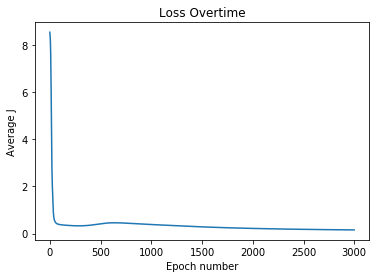

In [29]:
nn_network_sigmoid1.plot_loss()

In [30]:
y_pred = nn_network_sigmoid1.predict(X_test)
accuracy1 = nn_network_sigmoid1.accuracy(y_pred, y_test)
print("Prediction accuracy is {:.5f}%".format(accuracy1))

Prediction accuracy is 95.54937%


## Neural Network with structure [64, 30, 10] and ReLU activation

In [35]:
relu_activation = lambda X: np.maximum(0, X)
relu_activation_deriv = lambda x: (x > 0) * 1

nn_network_relu = FCNeuralNetwork([64, 30, 10], relu, relu_deriv)
nn_network_relu.fit(X_train, y_train_vect, 3000)

At epoch 0, mse-cost is 38.099762370878494
At epoch 300, mse-cost is 1.0
At epoch 600, mse-cost is 1.0
At epoch 900, mse-cost is 1.0
At epoch 1200, mse-cost is 1.0
At epoch 1500, mse-cost is 1.0
At epoch 1800, mse-cost is 1.0
At epoch 2100, mse-cost is 1.0
At epoch 2400, mse-cost is 1.0
At epoch 2700, mse-cost is 1.0

At epoch 3000, mse-cost is 1.0


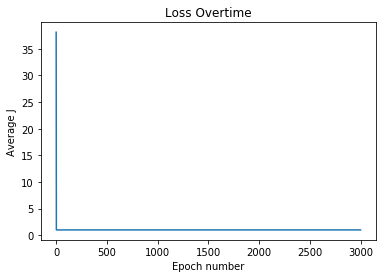

In [36]:
nn_network_relu.plot_loss()

In [37]:
y_pred = nn_network_relu.predict(X_test)
accuracy1 = nn_network_relu.accuracy(y_pred, y_test)
print("Prediction accuracy is {:5f}%".format(accuracy1))

Prediction accuracy is 10.292072%


## Neural Network with structure [64, 30, 10] and Tanh activation

In [31]:
nn_network_tanh = FCNeuralNetwork([64, 30, 10], tanh, tanh_deriv)
nn_network_tanh.fit(X_train, y_train_vect, 3000)

At epoch 0, mse-cost is 7.882650841912799
At epoch 300, mse-cost is 0.14458942026697574
At epoch 600, mse-cost is 0.12976616146247044
At epoch 900, mse-cost is 0.127162898552765
At epoch 1200, mse-cost is 0.12812455947448992
At epoch 1500, mse-cost is 0.12980444808986236
At epoch 1800, mse-cost is 0.13078460110069498
At epoch 2100, mse-cost is 0.13108952577624652
At epoch 2400, mse-cost is 0.1308423631188316
At epoch 2700, mse-cost is 0.13035140498725517

At epoch 3000, mse-cost is 0.13004189365723706


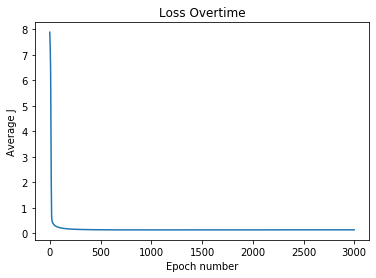

In [33]:
nn_network_tanh.plot_loss()

In [34]:
y_pred = nn_network_tanh.predict(X_test)
accuracy1 = nn_network_tanh.accuracy(y_pred, y_test)
print("Prediction accuracy is {:5f}%".format(accuracy1))

Prediction accuracy is 97.079277%


We observe the highest accuracy for the [64, 30, 10] neurons model with the `tanh` activation function with prediction accuracy of `97.079277%` followed by the model with the `sigmoid` activation with accuracy of `95.54937%` and finally the model with the ReLU performed dreadfully, not learning the training set at all with an accuracy of a mere `10%`.
